# Import everyting here

In [1]:
import torch.utils.data
import matplotlib.pyplot as plt
import torch
import scipy.integrate
import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger


from Euler import *

%reload_ext autoreload
%autoreload 2

/home/gergedan/.local/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Setup Tensorboard

In [3]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6006

In [4]:
# train_dataset[0] --> trajectory sets as dict
# train_dataset[0]["traj"] --> first trajectory set 
# train_dataset[0]["traj_shifted"] --> first trajectory set shifted by one (targets)
train_dataset = None # 100x10x2
validation_dataset = None
test_dataset = None

# Create dataset

FIRST VALUE:  -1.8575584283221693 0.1562957673078671
LAST VALUE:  -0.11418453335718692 -0.14564706665548685
FIRST VALUE:  -1.0615433868967887 -1.0510618851317854
LAST VALUE:  0.03352531956690032 -0.16630041574298884


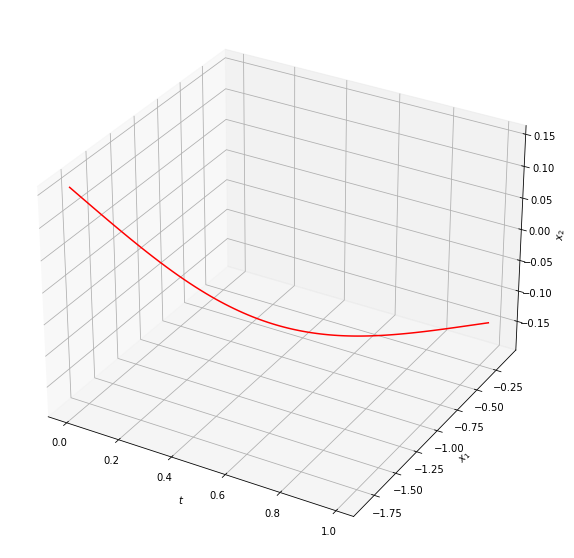

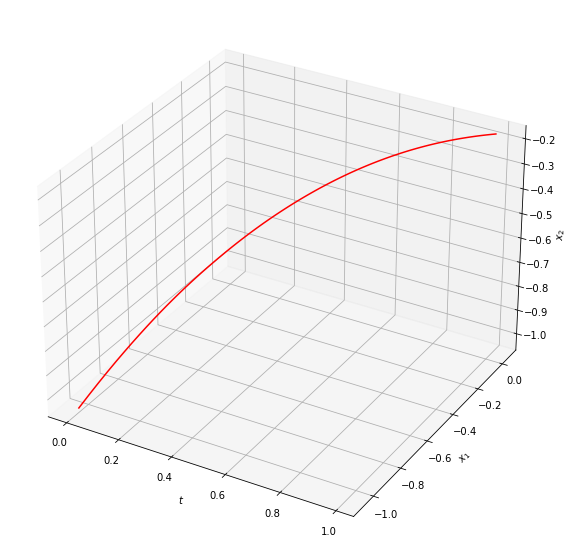

In [5]:
alpha = -1.8
delta_t = 0.01

def get_derivatives(x1, x2, alpha):
    """
    andronov hopf change name
    """
    return alpha * x1 - x2 - x1 * (x1 ** 2 + x2 ** 2), x1 + alpha * x2 - x2 * (x1 ** 2 + x2 ** 2)

start_positions = np.random.uniform(-2, 2, (1000, 2))
sols = []
t_eval = np.arange(0, 1, delta_t)

for start_position in start_positions:
    sol = scipy.integrate.solve_ivp(lambda t, y: get_derivatives(y[0], y[1], alpha), (0, 10) , start_position, t_eval=t_eval)
    sols.append(sol.y)

# plot both trajectories in 3D
fig = plt.figure(figsize=(10, 10))
ax0 = plt.axes(projection="3d")
ax0.plot(t_eval, sols[0][0], sols[0][1], label=r"Trajectory with starting point $(-3, -3)$", color="r")

ax0.set_xlabel(r"$t$")
ax0.set_ylabel(r"$x_1$")
ax0.set_zlabel(r"$x_2$")

print("FIRST VALUE: ", sols[0][0][0], sols[0][1][0])
print("LAST VALUE: ", sols[0][0][-1], sols[0][1][-1])

# plot both trajectories in 3D
fig = plt.figure(figsize=(10, 10))
ax0 = plt.axes(projection="3d")
ax0.plot(t_eval, sols[999][0], sols[999][1], label=r"Trajectory with starting point $(-3, -3)$", color="r")

ax0.set_xlabel(r"$t$")
ax0.set_ylabel(r"$x_1$")
ax0.set_zlabel(r"$x_2$")

print("FIRST VALUE: ", sols[999][0][0], sols[999][1][0])
print("LAST VALUE: ", sols[999][0][-1], sols[999][1][-1])

# some deep shit here

In [6]:
train_dataset_values = np.array(sols)

train_dataset_targets = np.delete(train_dataset_values, 0, axis=-1)
train_dataset_values = np.delete(train_dataset_values, -1, axis=-1)

print("train_dataset_values shape: ", train_dataset_values.shape)
print("train_dataset_targets shape: ", train_dataset_targets.shape)

train_dataset_values = np.moveaxis(train_dataset_values, 1, -1).reshape((train_dataset_values.shape[0] * train_dataset_values.shape[2], 2))
print("train_dataset_values shape: ", train_dataset_values.shape)

train_dataset_targets = np.moveaxis(train_dataset_targets, 1, -1).reshape((train_dataset_targets.shape[0] * train_dataset_targets.shape[2], 2))
print("train_dataset_targets shape: ", train_dataset_targets.shape)

train_dataset = np.stack((train_dataset_values, train_dataset_targets))
train_dataset = np.moveaxis(train_dataset, 0, 1)
print("train_dataset shape: ", train_dataset.shape)

train_dataset_values shape:  (1000, 2, 99)
train_dataset_targets shape:  (1000, 2, 99)
train_dataset_values shape:  (99000, 2)
train_dataset_targets shape:  (99000, 2)
train_dataset shape:  (99000, 2, 2)


In [7]:
"""
train_dataset = np.stack((train_dataset_values, train_dataset_targets))
print("train_dataset shape: ", train_dataset.shape)

train_dataset = np.moveaxis(train_dataset, 0, 1)
print("train_dataset shape: ", train_dataset.shape)

# As one can see, we could successfully generate the targets!
#print(train_dataset_values[0, :, :10])
#print(train_dataset_targets[0, :, :10])


#values_x = train_dataset_values[:, 0, :]
#values_y = train_dataset_values[:, 1, :]

#A = np.reshape(train_dataset_values, (1000, 9999, 2))
#print(A[0, :10, :])

#train_dataset_targets =

#(1000, 10000, 10000)

#((10000000, 2), (10000000, 2))
"""

'\ntrain_dataset = np.stack((train_dataset_values, train_dataset_targets))\nprint("train_dataset shape: ", train_dataset.shape)\n\ntrain_dataset = np.moveaxis(train_dataset, 0, 1)\nprint("train_dataset shape: ", train_dataset.shape)\n\n# As one can see, we could successfully generate the targets!\n#print(train_dataset_values[0, :, :10])\n#print(train_dataset_targets[0, :, :10])\n\n\n#values_x = train_dataset_values[:, 0, :]\n#values_y = train_dataset_values[:, 1, :]\n\n#A = np.reshape(train_dataset_values, (1000, 9999, 2))\n#print(A[0, :10, :])\n\n#train_dataset_targets =\n\n#(1000, 10000, 10000)\n\n#((10000000, 2), (10000000, 2))\n'

# Define hyperparameters

In [8]:
hparams = {
    "hidden_layer_1": 512,
    "hidden_layer_2": 512,
    "hidden_layer_3": 512,
    "delta_t": delta_t,
    "batch_size": 256,
    "learning_rate": 1e-3,
    "num_workers": 8,
}

In [9]:
model = Euler(hparams)

# Validation set

In [10]:
start_positions = np.random.uniform(-2, 2, (200, 2))

sols = []
t_eval = np.arange(0, 10, delta_t)

for start_position in start_positions:
    sol = scipy.integrate.solve_ivp(lambda t, y: get_derivatives(y[0], y[1], alpha), (0, 10) , start_position, t_eval=t_eval)
    sols.append(sol.y)
    
validation_dataset_values = np.array(sols)

validation_dataset_targets = np.delete(validation_dataset_values, (0), axis=-1)
validation_dataset_values = np.delete(validation_dataset_values, (-1), axis=-1)

validation_dataset_values = np.moveaxis(validation_dataset_values, 1, -1).reshape((validation_dataset_values.shape[0] * validation_dataset_values.shape[2], 2))

validation_dataset_targets = np.moveaxis(validation_dataset_targets, 1, -1).reshape((validation_dataset_targets.shape[0] * validation_dataset_targets.shape[2], 2))

validation_dataset = np.stack((validation_dataset_values, validation_dataset_targets))

validation_dataset = np.moveaxis(validation_dataset , 0, 1)


print("VAL DATASET SHAPE:", validation_dataset.shape)

def evaluate_model(model, dataset):
    """
    TODO
    """
    model.eval()
    model.to(device)
    criterion = torch.nn.MSELoss()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=hparams["batch_size"], shuffle=False)
    loss = 0
    for batch in dataloader:
        pos = batch[:, 0]
        pos_target = batch[:, 1]
        
        pos = pos.to(device)
        pos_target = pos_target.to(device)
        
        #x = torch.flatten(traj).to(device)
        #y = torch.flatten(traj_shifted).to(device)
        
        pred = model.forward(pos.float()).to(device)
        
        loss += criterion(pred, pos_target.float()).item()
    return 1.0 / (2 * (loss/len(dataloader)))


def recreate_trajectory(model, start_position, t_start, t_end, delta_t):
    """
    TODO
    """
    trajectory = [start_position]
    last_traj = torch.tensor(start_position)
    
    last_traj = last_traj.to(device)
    
    t0 = t_start
    while t0 <= t_end:
        last_traj = last_traj + delta_t * model(last_traj)
        trajectory.append(last_traj)
        
        t0 += delta_t
        
    return trajectory


print("Score of the Model before training:", evaluate_model(model, validation_dataset))

# plot the first one
recreation = recreate_trajectory(model, start_positions[0], t_eval[0], t_eval[-1], delta_t)
recreation = np.array(recreation)

fig = plt.figure(figsize=(10, 10))
ax0 = plt.axes(projection="3d")
ax0.plot(t_eval, recreation[0], recreation[1], label=r"Trajectory with starting point $(-3, -3)$", color="r")

ax0.set_xlabel(r"$t$")
ax0.set_ylabel(r"$x_1$")
ax0.set_zlabel(r"$x_2$")


print("FIRST VALUE: ", recreation[0][0], recreation[0][1])
print("LAST VALUE: ", recreation[-1][0], recreation[-1][1])


VAL DATASET SHAPE: (199800, 2, 2)
Score of the Model before training: 21018.321287538944


RuntimeError: expected scalar type Double but found Float

In [11]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                         shuffle=False,
                                         batch_size=hparams["batch_size"],
                                         num_workers=8)
validation__dataloader = torch.utils.data.DataLoader(validation_dataset,
                                         shuffle=False,
                                         batch_size=hparams["batch_size"],
                                         num_workers=8)

In [12]:
trainer = pl.Trainer(
    max_epochs=5,
    log_every_n_steps=1,
    gpus=1 if torch.cuda.is_available() else None
)

trainer.fit(model, train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 527 K 
-------------------------------------
527 K     Trainable params
0         Non-trainable params
527 K     Total params
2.111     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [13]:
print("Score of the Model after training:", evaluate_model(model, validation_dataset))

Score of the Model after training: 17983573.60805339


In [ ]:
#Score of the Model before training: 21018.321287538944